In [1]:
# Requirements - uncomment as needed
#!pip install pystan matplotlib numpy scipy phyre

# Generating the scenario dataset

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import scipy.stats as sts

import phyre

In [3]:
# Choosing a setup where only one ball is needed
eval_setup = 'ball_cross_template'

# Getting just one fold of scenarios from the simulator
fold_id = 4

# Getting the tasks split into training, validation, and test
train_tasks, dev_tasks, test_tasks = phyre.get_fold(eval_setup, fold_id)
print('Size of resulting splits:\n train:', len(train_tasks), '\n dev:',
      len(dev_tasks), '\n test:', len(test_tasks))

Size of resulting splits:
 train: 1600 
 dev: 400 
 test: 500


In [4]:
print('All eval setups:', *phyre.MAIN_EVAL_SETUPS)
# For now, let's select cross template for ball tier.
eval_setup = 'ball_cross_template'

All eval setups: ball_cross_template ball_within_template two_balls_cross_template two_balls_within_template


In [5]:
# Getting action tier for our tasks - a single ball
action_tier = phyre.eval_setup_to_action_tier(eval_setup)
print('Action tier for', eval_setup, 'is', action_tier)

Action tier for ball_cross_template is ball


In [6]:
# Let's set our tasks to first 50 of the dev set 
tasks = test_tasks

task_index = list(tasks).index('00015:418')
print(task_index)

# Create the simulator from the tasks and tier.
simulator = phyre.initialize_simulator(tasks, action_tier)

171


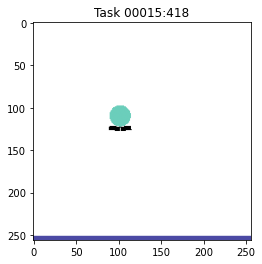

In [7]:
# Showing the tasks
initial_scene = simulator.initial_scenes[task_index]
plt.imshow(phyre.observations_to_float_rgb(initial_scene))
plt.title(f'Task {simulator.task_ids[task_index]}');
plt.show()

In [8]:
actions = simulator.build_discrete_action_space(max_actions=100)
print('A random action:', actions[0])

A random action: [4.17022005e-01 7.20324493e-01 1.14374817e-04]


In [9]:
target_action = None

for action in actions:
    simulation = simulator.simulate_action(task_index, action, need_images=True, need_featurized_objects=True, stride=15)
    if simulation.status.is_solved():
        target_action = action
        break

In [10]:
# Let's take a look at target action that solves the task
# The most important for us - it makes green object move
target_action

array([0.53844059, 0.86660827, 0.94980599])

Number of observations returned by simulator: 48


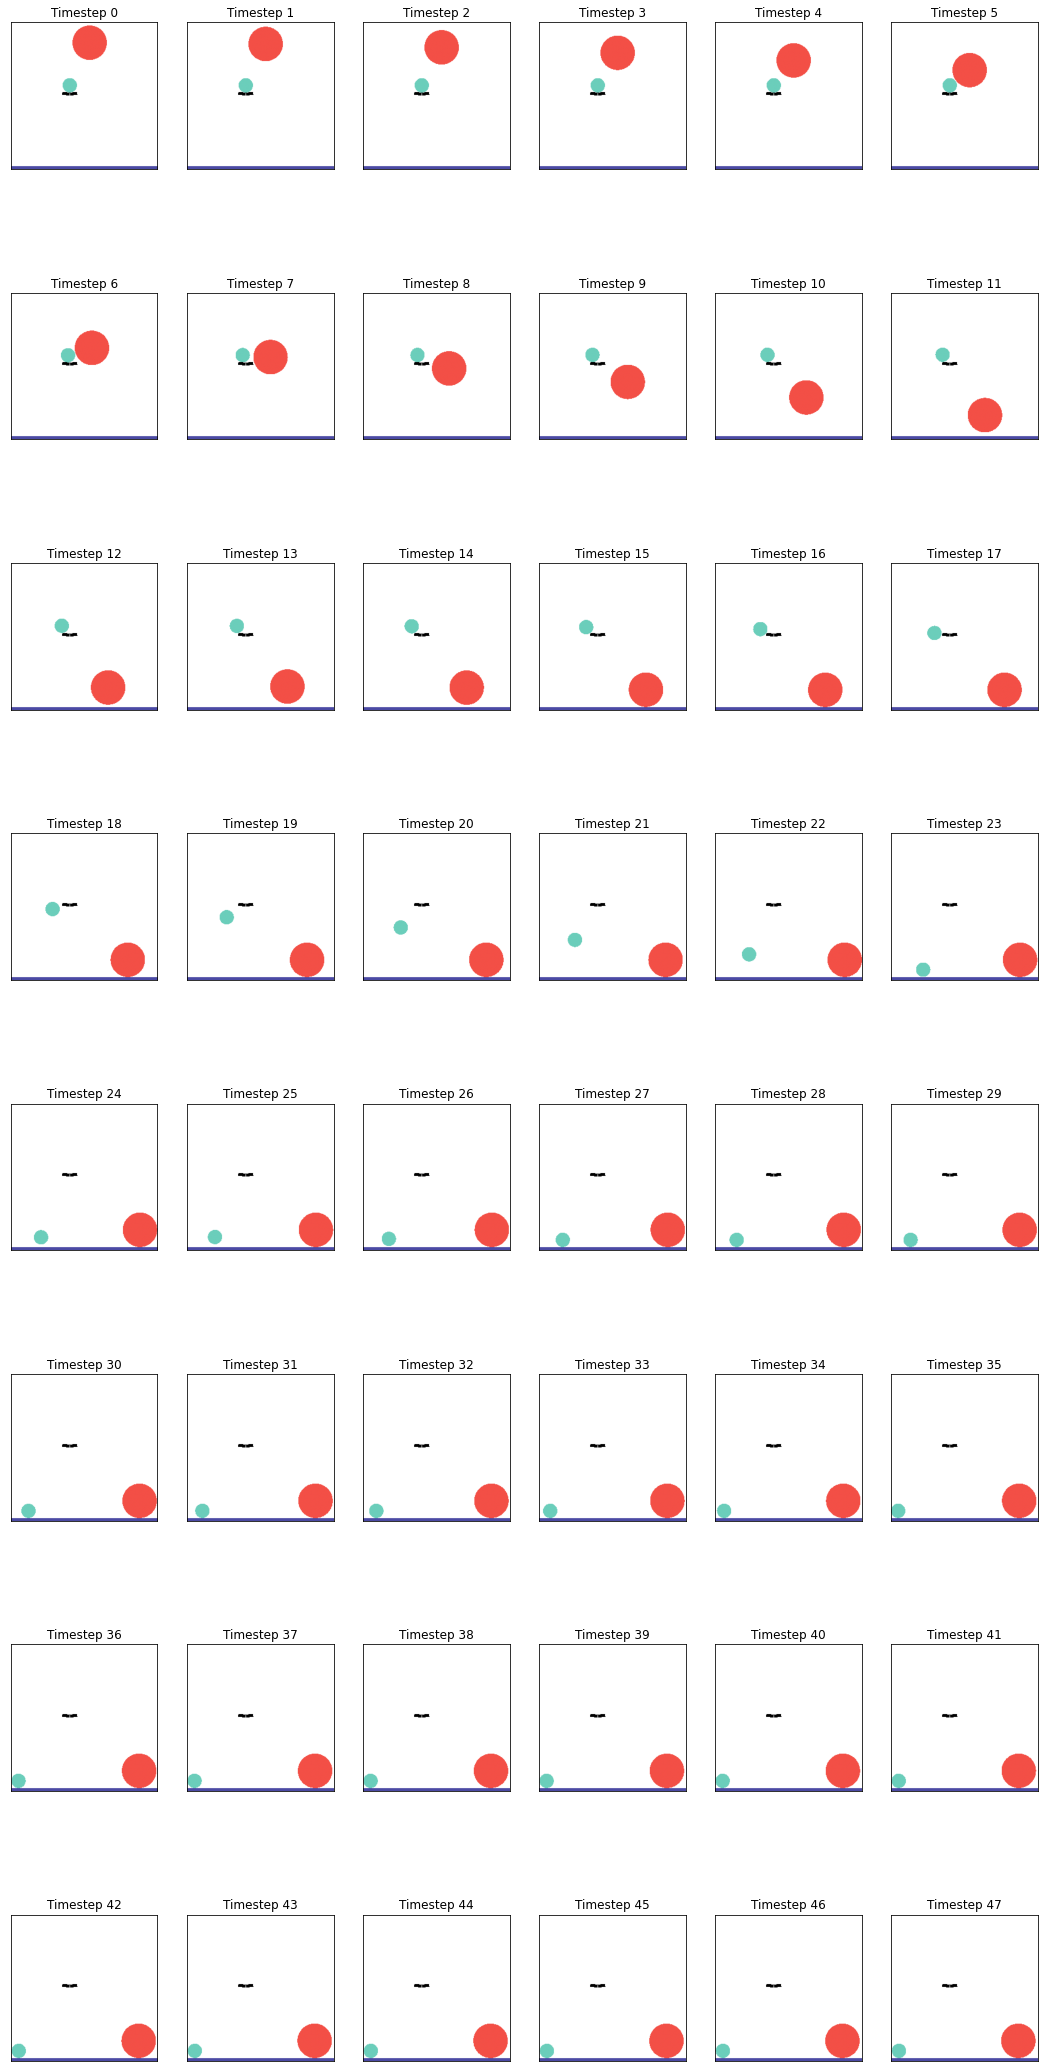

In [11]:
# Displaying the simulation
print('Number of observations returned by simulator:', len(simulation.images))

num_across = 6
height = int(math.ceil(len(simulation.images) / num_across))
fig, axs = plt.subplots(height, num_across, figsize=(15, 30))
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)

# We can visualize the simulation at each timestep.
for i, (ax, image) in enumerate(zip(axs.flatten(), simulation.images)):
    # Convert the simulation observation to images.
    img = phyre.observations_to_float_rgb(image)
    ax.imshow(img)
    ax.title.set_text(f'Timestep {i}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
plt.savefig('simulation.png')

In [12]:
# We can also get the response from the simulator in a matrix form
featurized_objects = simulation.featurized_objects

# I am interested in saving coordinates and diameters for every object
# This is because I am limiting my model to work only with balls, so these features are enough
# The last component of the output corresponds to the red ball - the one we are interested in

# X-coordinates by frame
print('X-coordinates by frame')
print(featurized_objects.xs)
print()

# Y-coordinates by frame
print('Y-coordinates by frame')
print(featurized_objects.ys)
print()

# Diameters
print('Diameters')
print(featurized_objects.diameters)

X-coordinates by frame
[[0.5        0.3742236  0.42577642 0.40000004 0.53515625]
 [0.5        0.3742236  0.42577642 0.39998055 0.53515625]
 [0.5        0.3742236  0.42577642 0.3999779  0.53515625]
 [0.5        0.3742236  0.42577642 0.39997816 0.53515625]
 [0.5        0.3742236  0.42577642 0.39997816 0.53515625]
 [0.5        0.3742236  0.42577642 0.39997816 0.53515625]
 [0.5        0.3742236  0.42577642 0.38817456 0.5506761 ]
 [0.5        0.3742236  0.42577642 0.3791516  0.5684055 ]
 [0.5        0.3742236  0.42577642 0.37096527 0.5861349 ]
 [0.5        0.3742236  0.42577642 0.3636157  0.6038643 ]
 [0.5        0.3742236  0.42577642 0.35710225 0.6215937 ]
 [0.5        0.3742236  0.42577642 0.35138795 0.6393231 ]
 [0.5        0.3742236  0.42577642 0.34588903 0.6607702 ]
 [0.5        0.3742236  0.42577642 0.339613   0.68313104]
 [0.5        0.3742236  0.42577642 0.33155885 0.70549196]
 [0.5        0.3742236  0.42577642 0.32101673 0.727837  ]
 [0.5        0.3742236  0.42577642 0.30853754 0.7

In [13]:
# We can see that the last feature of each frame corresponds to the red ball
# The only other feature that changes is the one before last - so it corresponds to green object
# Let's save it separately
GROUND_TRUTH_x_coordinates = [x[3] for x in featurized_objects.xs]
GROUND_TRUTH_y_coordinates = [y[3] for y in featurized_objects.ys]
ball_diameter = featurized_objects.diameters[3]

In [14]:
def generate_observations(true_x, true_y):
    return np.array([[true_x[i] + sts.norm(0, 0.05).rvs(), true_y[i] + sts.norm(0, 0.05).rvs()] for i in range(len(true_x))])

In [15]:
observations = generate_observations(GROUND_TRUTH_x_coordinates, GROUND_TRUTH_y_coordinates)
observations

array([[ 4.08175119e-01,  6.13252875e-01],
       [ 4.16467280e-01,  5.08347324e-01],
       [ 4.53757460e-01,  5.64931292e-01],
       [ 4.47257364e-01,  5.65336389e-01],
       [ 3.40140794e-01,  6.15562969e-01],
       [ 4.53386155e-01,  5.55763967e-01],
       [ 3.73847156e-01,  5.94205889e-01],
       [ 4.37978973e-01,  5.77930396e-01],
       [ 3.34104357e-01,  5.61697536e-01],
       [ 3.62003465e-01,  5.49449994e-01],
       [ 4.11706404e-01,  6.10077379e-01],
       [ 2.27527542e-01,  6.27481759e-01],
       [ 3.72376474e-01,  5.67200994e-01],
       [ 2.54489994e-01,  5.49898916e-01],
       [ 3.47112149e-01,  5.53696263e-01],
       [ 3.49724547e-01,  5.61097658e-01],
       [ 3.01003703e-01,  5.81822635e-01],
       [ 3.12644964e-01,  4.47664211e-01],
       [ 2.27601098e-01,  4.60381220e-01],
       [ 2.94659484e-01,  3.94420257e-01],
       [ 2.08606946e-01,  3.75774267e-01],
       [ 3.24417985e-01,  2.29567939e-01],
       [ 2.87363420e-01,  7.20326086e-02],
       [ 1.

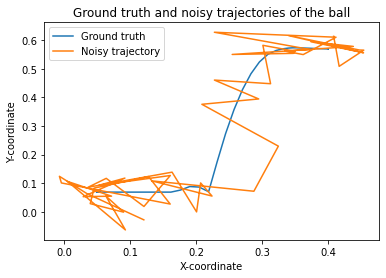

In [27]:
plt.plot(GROUND_TRUTH_x_coordinates, GROUND_TRUTH_y_coordinates, label='Ground truth')
plt.plot(observations.transpose()[0], observations.transpose()[1], label='Noisy trajectory')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.title('Ground truth and noisy trajectories of the ball')
plt.legend()
plt.show() 

# Modeling

Let's start with the mathematical definition of our 2D extension of GPS model.

As an initial frame of the model I will take the fourth frame of the simulation, assuming that on the fourth frame the ball is already free-falling.

Notation:

- $\tilde x_t$ - x-coordinate at time t

- $\tilde y_t$ - y-coordinate at time t

- $x_t$ - measurement of x-coordinate at time t

- $y_t$ - measurement of y-coordinate at time t

- $v_{xt}$ - x-component of velocity at time t

- $v_{yt}$ - y-component of velocity at time t

- $g$ - free-fall acceleration

Initial state:

- x-coordinate: $x_0 \sim N(\mu_{x0}, \sigma_{x0}^2)$

- y-coordinate: $y_0 \sim N(\mu_{x0}, \sigma_{x0}^2)$

- x-component of velocity: $v_{x0} \sim N(\mu_{v_{x0}}, \sigma_{v_{x0}}^2)$

- y-component of velocity: $v_{y0} \sim N(\mu_{v_{y0}}, \sigma_{v_{y0}}^2)$

Parameter values:

- $\mu_{v_{x0}} = x_0 - x{-1}$ (where -1 refers to the preceeding simulation frame)

- $\mu_{v_{y0}} = y_0 - y_{-1}$

- $g = v_{y1} - v{y0}$ - free fall acceleration

State update equations:

- x-coordinate: $\tilde x_{t+1} \sim N(\tilde x_t + v_{xt}, \sigma_{\tilde x}^2)$

- y-coordinate: $\tilde y_{t+1} \sim N(\tilde y_t + v_{yt}, \sigma_{\tilde y}^2)$

- x-component of velocity: $v_{xt+1} \sim N(v_{xt}, \sigma_{v_{x}}^2)$

- y-component of velocity: $v_{yt+1} \sim N(v_{yt} + g, \sigma_{v_{y}}^2)$

Measurement equations:

- $x_t \sim N(\tilde x_t, \sigma_{x}^2)$

- $y_t \sim N(\tilde y_t, \sigma_{y}^2)$

## Graphs for the model

![](directed.png)

![](factor.png)

In [16]:
import pystan

In [73]:
frame_0_idx = 15

data = {
    'T': len(observations)-frame_0_idx-1,
    
    # initial positions
    'mu_tilde_x0': observations[frame_0_idx][0],
    'sigma_tilde_x0': 0.01,
    'mu_tilde_y0': observations[frame_0_idx][1],
    'sigma_tilde_y0': 0.01,
    
    # initial velocities
    'mu_vx0': observations[frame_0_idx][0] - observations[frame_0_idx-1][0],
    'sigma_vx0': 0.02,
    'mu_vy0': observations[frame_0_idx][1] - observations[frame_0_idx-1][1],
    'sigma_vy0': 0.02,
    
    # free fall acceleration
    'g': observations[frame_0_idx+4][1] - observations[frame_0_idx+3][1],
    
    # measurements
    'sigma_x': 0.05,
    'sigma_tilde_x': 0.001,
    'sigma_y': 0.05,
    'sigma_tilde_y': 0.001,
    'sigma_vx': 0.1,
    'sigma_vy': 0.1,
    'x': observations.transpose()[0][frame_0_idx:],
    'y': observations.transpose()[1][frame_0_idx:]
}

In [18]:
# Source of inspirtion for this model - the 1D GPS model from the class
# https://course-resources.minerva.edu/uploaded_files/mke/00085235-3234/gps-model-stan.py

stan_code = '''

data {
    int<lower=1> T;
    real mu_tilde_x0;
    real<lower=0> sigma_tilde_x0;
    real mu_tilde_y0;
    real<lower=0> sigma_tilde_y0;
    real mu_vx0;
    real<lower=0> sigma_vx0;
    real mu_vy0;
    real<lower=0> sigma_vy0;
    real<upper=0> g;
    real<lower=0> sigma_x;
    real<lower=0> sigma_tilde_x;
    real<lower=0> sigma_y;
    real<lower=0> sigma_tilde_y;
    real<lower=0> sigma_vx;
    real<lower=0> sigma_vy;
    real x[T+1];
    real y[T+1];
}

parameters {
    real tilde_x[T+1];
    real tilde_y[T+1];
    real vx[T+1];
    real vy[T+1];
}

model {
    tilde_x[1] ~ normal(mu_tilde_x0, sigma_tilde_x0);
    tilde_y[1] ~ normal(mu_tilde_y0, sigma_tilde_y0);
    vx[1] ~ normal(mu_vx0, sigma_vx0);
    vy[1] ~ normal(mu_vy0, sigma_vy0);
    
    for (t in 1:T) {
        tilde_x[t+1] ~ normal(tilde_x[t] + vx[t], sigma_tilde_x);
        tilde_y[t+1] ~ normal(tilde_y[t] + vy[t], sigma_tilde_y);
        vx[t+1] ~ normal(vx[t], sigma_vx);
        vy[t+1] ~ normal(vy[t] + g, sigma_vy);
    }
    
    x ~ normal(tilde_x, sigma_x);
    y ~ normal(tilde_y, sigma_y);
}

generated quantities {
    real x_pred[T+1];
    real y_pred[T+1];
    
    for (t in 1:(T+1)) {
        x_pred[t] = normal_rng(tilde_x[t], sigma_x);
        y_pred[t] = normal_rng(tilde_y[t], sigma_y);
    }
}

'''

In [19]:
stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b6fbb2b7c012b63009df54154e8088ae NOW.


In [74]:
results = stan_model.sampling(data=data)

In [75]:
print(results)

Inference for Stan model: anon_model_b6fbb2b7c012b63009df54154e8088ae.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
tilde_x[1]    0.35  1.0e-4 9.3e-3   0.33   0.34   0.35   0.35   0.37   7883    1.0
tilde_x[2]    0.34  2.0e-4   0.02    0.3   0.33   0.34   0.35   0.38   9653    1.0
tilde_x[3]     0.3  4.1e-4   0.04   0.24   0.28    0.3   0.33   0.37   7732    1.0
tilde_x[4]    0.26  4.5e-4   0.04   0.18   0.23   0.26   0.28   0.33   6990    1.0
tilde_x[5]    0.26  3.8e-4   0.04   0.19   0.24   0.26   0.29   0.34   9913    1.0
tilde_x[6]    0.25  3.7e-4   0.04   0.18   0.23   0.25   0.28   0.33  10635    1.0
tilde_x[7]    0.29  4.3e-4   0.04   0.21   0.26   0.29   0.32   0.36   7907    1.0
tilde_x[8]    0.26  4.1e-4   0.04   0.19   0.24   0.26   0.29   0.33   8548    1.0
tilde_x[9]    0.19  4.3e-4   0.04   0.12   0.16   0.19   0.21   

In [76]:
samples = results.extract()

Let's now plot the measured and predicted trajectories, as well as time evolution of the coordinates over time, to visualize the results of the modeling.

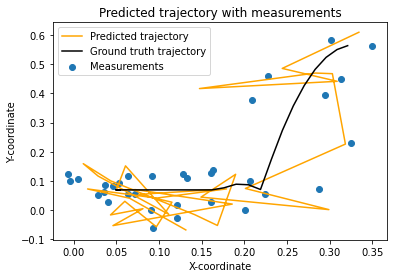

In [77]:
plt.scatter(observations.transpose()[0][frame_0_idx:],\
            observations.transpose()[1][frame_0_idx:], label='Measurements')
plt.plot(samples['x_pred'][0], samples['y_pred'][0],\
         color='orange', label='Predicted trajectory')
plt.plot(GROUND_TRUTH_x_coordinates[frame_0_idx:], GROUND_TRUTH_y_coordinates[frame_0_idx:],\
        label='Ground truth trajectory', color='black')
plt.title('Predicted trajectory with measurements')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

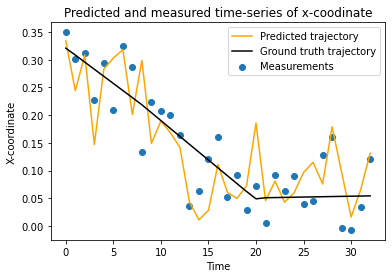

In [78]:
plt.scatter(range(len(observations) - frame_0_idx),\
            observations.transpose()[0][frame_0_idx:], label='Measurements')
plt.plot(samples['x_pred'][0], label='Predicted trajectory', color='orange')
plt.plot(range(len(observations) - frame_0_idx), GROUND_TRUTH_x_coordinates[frame_0_idx:],\
        label='Ground truth trajectory', color='black')
plt.title('Predicted and measured time-series of x-coodinate')
plt.xlabel('Time')
plt.ylabel('X-coordinate')
plt.legend()
plt.show()

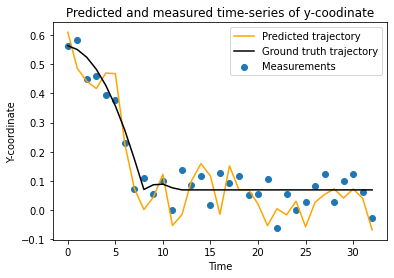

In [79]:
plt.scatter(range(len(observations) - frame_0_idx),\
            observations.transpose()[1][frame_0_idx:], label='Measurements')
plt.plot(samples['y_pred'][0], label='Predicted trajectory', color='orange')
plt.plot(range(len(observations) - frame_0_idx), GROUND_TRUTH_y_coordinates[frame_0_idx:],\
        label='Ground truth trajectory', color='black')
plt.title('Predicted and measured time-series of y-coodinate')
plt.xlabel('Time')
plt.ylabel('Y-coordinate')
plt.legend()
plt.show()

In [28]:
len(samples['x_pred'])

4000